In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import collections
import random

from typing import Any, Dict, List, Tuple, Union
from pathlib import Path

from recommend.utils import PROJ_ROOT

# Utility functions

In [4]:
def creators2list(creators : str, top_n_actors : int = 3) -> List[str]:
    """Returns a list of `top_n_actors`, director, and a composer."""
    result = []
    
    if 'Hrají' in creators:
        result = creators['Hrají'][:top_n_actors]
        result = list(map(lambda x: x[1], result))

    if 'Režie' in creators:
        result += [creators['Režie'][0][1]]
    if 'Hudba' in creators:
        result += [creators['Hudba'][0][1]]
    return result


def analyse_freq(list_of_lists : List[List[Any]]) -> List[Tuple[Any, int]]:
    """
    Counts occurences of items in a list of lists
    and returns them in descending order as tuples <item, count>."""

    flat_list = [item for sublist in list_of_lists for item in sublist]
    counter = collections.Counter(flat_list)
    return counter.most_common(len(counter))


# Load datasets

In [7]:
movies = pd.read_pickle(PROJ_ROOT / 'data' / 'movies.pkl')
ratings = pd.read_pickle(PROJ_ROOT / 'data' / 'ratings.pkl')

# Drop irrelevant columns
movies = movies.drop(columns=['kind', 'length', 'poster', 'foreign_titles'])

# Convert creators column to list of creators
movies['creators'] = movies['creators'].apply(creators2list)
#movies.reset_index(inplace=True) # causes trouble with join

display(movies.head(3))
ratings.head(3)

,title,description,genres,countries,year,creators
movie_id,,,,,,
230421-houbicky,Houbičky,"Partička amerických teenagerů, která si vyrazi...","[Horor, Thriller]","[Irsko, Velká Británie, Dánsko]",2007,"[Lindsey Haun, Jack Huston, Max Kasch, Paddy B..."
10789-prvni-liga,První liga,V nejvyšší lize získávají hráči baseballu boha...,"[Komedie, Sportovní]",[USA],1989,"[Tom Berenger, Charlie Sheen, Corbin Bernsen, ..."
235032-yes-man,Yes Man,"Carl Allen je zatrpklý bankovní úředník, který...","[Komedie, Romantický]",[USA],2008,"[Jim Carrey, Zooey Deschanel, Bradley Cooper, ..."


,username,movie_id,stars,date,comment
0,kinghome,230421-houbicky,5.0,2011-11-13,Hodnocení některých šašků tady opravdu necháp...
1,SimonShot,230421-houbicky,5.0,2012-12-19,Tento snímek je zajímavý už jenom tím že se n...
2,blackend,230421-houbicky,5.0,2010-09-04,Pohoda a vzhledem k dobré atmosféře a nízkému...


In [8]:
# get mean rating of each film 
avg_ratings = ratings[['movie_id', 'stars']].groupby(['movie_id']).mean()
avg_ratings.rename(columns={'stars': 'avg_stars'}, inplace=True)

# get rating count of each film
count_ratings = ratings[['movie_id', 'stars']].groupby('movie_id').count()
count_ratings.rename(columns={'stars': 'num_ratings'}, inplace=True)
count_ratings

# join with the movies database
movie_db = movies.join(avg_ratings).join(count_ratings).sort_values(by='num_ratings')
movie_db = movie_db.reset_index()
movie_db

,movie_id,title,description,genres,countries,year,creators,avg_stars,num_ratings
0,75613-hercule-poirot_498504-serie-9,Hercule Poirot,Malý belgický detektiv Hercule Poirot (David S...,"[Krimi, Drama, Mysteriózní, Thriller]",[Velká Británie],(1989–2013),"[David Suchet, Hugh Fraser, Philip Jackson, Ed...",5.000000,1
1,613789-obeti,Oběti,Na televizní obrazovku se vrací cyklus o lide...,[Drama],[Česko],(1999–2008),"[Zbyněk Fric, Karel Zima, Libor Žídek, Petr Sl...",5.000000,1
2,75613-hercule-poirot_498507-serie-12,Hercule Poirot,Malý belgický detektiv Hercule Poirot (David S...,"[Krimi, Drama, Mysteriózní, Thriller]",[Velká Británie],(1989–2013),"[David Suchet, Hugh Fraser, Philip Jackson, Ed...",4.500000,2
3,350930-krtek,Krtek,,"[Animovaný, Dobrodružný]","[Česko, Finsko]",2011,"[Zdeněk Miler, Wiliam Bukový]",4.500000,2
4,33863-bajaja,Bajaja,Jiří Trnka natočil v roce 1950 volně podle poh...,"[Animovaný, Loutkový, Pohádka]",[Československo],1950,"[Jiří Trnka, Václav Trojan]",4.285714,14
...,...,...,...,...,...,...,...,...,...
8669,232938-hobit-neocekavana-cesta,Hobit: Neočekávaná cesta,Film sleduje cestu hlavní postavy Bilbo Pytlík...,"[Dobrodružný, Fantasy]","[USA, Nový Zéland]",2012,"[Martin Freeman, Ian McKellen, Richard Armitag...",3.953150,3159
8670,227786-interstellar,Interstellar,Příběh se odehrává v nepříliš vzdálené budoucn...,"[Sci-Fi, Dobrodružný, Drama]","[USA, Velká Británie, Kanada]",2014,"[Matthew McConaughey, Anne Hathaway, Jessica C...",4.072779,3174
8671,223734-temny-rytir,Temný rytíř,Další Batmanovo dobrodružství začíná. Jeho pro...,"[Akční, Drama, Krimi, Thriller]","[USA, Velká Británie]",2008,"[Christian Bale, Heath Ledger, Aaron Eckhart, ...",4.559151,3770
8672,254156-pocatek,Počátek,Dom Cobb (Leonardo DiCaprio) je velmi zkušený ...,"[Akční, Sci-Fi, Thriller, Mysteriózní, Dobrodr...","[USA, Velká Británie]",2010,"[Leonardo DiCaprio, Joseph Gordon-Levitt, Elli...",4.368000,4000



# Recommendation Systems
---
## Base class

In [9]:
import abc

class RecSysBase(abc.ABC):
    """
    Recommendation System Base class.
    
    The system should store a database of available movies.
    
    """
    def __init__(self, movies_df : pd.DataFrame):
        self.movies_df = movies_df

    @abc.abstractmethod
    def recommend(self, user_history : List[str], n : int = 10, return_df : bool = False) -> Union[List[str], pd.DataFrame]:
        """
        Generates recommendations based on user's history of rated movies.
        
        Parameters
        ----------
        user_history : List[str]
            A list of movie ids a user has rated so far.
            
        n : int
            The number of recommendations to return.
        
        Returns
        -------
        Union[List[str], pd.DataFrame]
            By default returns a list of strings representeing movie ids.
            If `return_df` is set to True then a pandas dataframe.
        """
        # TODO: do we need `user_history` as List?
        # use List if: some systems use the order of items (e.g. preference of recent movies)
        # use Set if: we dont care at all about 
        pass

    def get_candidate_movies(self, user_history : List[str]) -> pd.DataFrame:
        """Returns a list of candidates by filtering movies a user has already seen."""
        df = pd.concat([self.movies_df, self._ids2df(user_history)])
        # convert to str because drop_duplicates does not work on dfs containing structures
        return df.loc[df.astype(str).drop_duplicates(keep=False).index]

    def _ids2df(self, user_history : List[str]) -> pd.DataFrame:
        """For a list of movie ids returns a dataframe compatible with `self.movies_df`"""
        mask = self.movies_df['movie_id'].isin(user_history)
        return self.movies_df.loc[mask]

    
    

## Random recommendations

In [10]:
import random

class RandomRS(RecSysBase):
    """
    System that recommends movies randomly.
    """
    def __init__(self, movies_df : pd.DataFrame):
        super(RandomRS, self).__init__(movies_df)

    def recommend(self, user_history : List[str], n : int = 10, return_df : bool = False) -> List[str]:
        """
        Recommends n random movies.
        Movies from `user_history` do not appear in the recommendations.
        """
        recommendations = self.get_candidate_movies(user_history).sample(n)
        return recommendations if return_df else recommendations.movie_id
    


In [11]:
rnd_rs = RandomRS(movie_db)

rnd_rs.recommend([], 3, return_df=True)

,movie_id,title,description,genres,countries,year,creators,avg_stars,num_ratings
4347,223205-mutant,Mutant,"Film začínající na vojenské základně v Korei, ...","[Horor, Komedie, Thriller, Sci-Fi, Akční]",[Jižní Korea],2006,"[Kang-ho Song, Doo-na Bae, Hae-il Park, Džun-h...",3.079787,188
3889,1330-upiri,Upíři,Parta Jacka Crowa (James Woods) pracuje jako z...,"[Horor, Akční, Thriller]",[USA],1998,"[James Woods, Daniel Baldwin, Sheryl Lee, John...",3.103659,164
1163,13229-bily-tesak,Bílý tesák,Naivní a nezkušený mladý dobrodruh Jack Conroy...,"[Dobrodružný, Drama]",[USA],1991,"[Klaus Maria Brandauer, Ethan Hawke, Seymour C...",3.552632,76


## Recommendation based on movie popularity

In [12]:

class PopularityRS(RecSysBase):
    """
    System recommends top n most popular movies a user has not rated yet.
    """
    def __init__(self, movies_df : pd.DataFrame):
        super(PopularityRS, self).__init__(movies_df)

    def recommend(self, user_history : List[str], n : int = 10, return_df : bool = False) -> List[str]:
        """
        Recommends n most rated movies a user has not yet seen.
        """
        recommendations = self.get_candidate_movies(user_history).sort_values(by='num_ratings').tail(n)
        return recommendations if return_df else recommendations.movie_id
    

In [13]:
avatar = '228329-avatar'
inception = '254156-pocatek'

rs = PopularityRS(movie_db)

rs.recommend([avatar], 3, return_df=True)

,movie_id,title,description,genres,countries,year,creators,avg_stars,num_ratings
8670,227786-interstellar,Interstellar,Příběh se odehrává v nepříliš vzdálené budoucn...,"[Sci-Fi, Dobrodružný, Drama]","[USA, Velká Británie, Kanada]",2014,"[Matthew McConaughey, Anne Hathaway, Jessica C...",4.072779,3174
8671,223734-temny-rytir,Temný rytíř,Další Batmanovo dobrodružství začíná. Jeho pro...,"[Akční, Drama, Krimi, Thriller]","[USA, Velká Británie]",2008,"[Christian Bale, Heath Ledger, Aaron Eckhart, ...",4.559151,3770
8672,254156-pocatek,Počátek,Dom Cobb (Leonardo DiCaprio) je velmi zkušený ...,"[Akční, Sci-Fi, Thriller, Mysteriózní, Dobrodr...","[USA, Velká Británie]",2010,"[Leonardo DiCaprio, Joseph Gordon-Levitt, Elli...",4.368000,4000


## TF-IDF Model

In [14]:
from multiprocessing import get_context
from gensim.corpora import Dictionary
from gensim.matutils import cossim
from gensim.models import TfidfModel
from gensim.similarities import SparseMatrixSimilarity
from gensim.utils import simple_preprocess
from tqdm import tqdm


class TfidfRS(RecSysBase):
    """
    System recommends unseen movies using TF-IDF on descriptions
    """
    def __init__(self, movies_df : pd.DataFrame):
        super(TfidfRS, self).__init__(movies_df)
        
        documents = movie_db.description.to_list()       
        doc_tokens = pool.imap(self.__class__._document_to_tokens, documents)
        doc_tokens = tqdm(document_bodies, desc='Building the dictionary', total=len(documents))
        self.dictionary = Dictionary(doc_tokens)
        
        doc_bows = pool.imap(self.__class__._document_to_bag_of_words, documents)
        doc_bows = tqdm(document_vectors, desc='Building the TF-IDF model', total=len(documents))
        self.tfidf_model = TfidfModel(doc_bows)
        
        doc_vectors = pool.imap(self.__class__._document_to_tfidf_vector, documents)
        doc_vectors = tqdm(document_vectors, desc='Building the TF-IDF index', total=len(documents))
        self.index = SparseMatrixSimilarity(document_vectors, num_docs=len(documents), num_terms=len(self.dictionary))
        
    
    def recommend(self, user_history : List[str], n : int = 10, return_df : bool = False) -> List[str]:
        """Retrieves top n unseen movies based cosine similarity on sparse tfidf vectors."""
        candidates = self.get_candidate_movies(user_history)
        candidates_descriptions = candidates.description.to_list()
        # TODO: what represents the "query"? => stuff last n movies into a single "doc"??


    @classmethod
    def _document_to_tokens(cls, document: str) -> List[str]:
        return simple_preprocess(document)
    
    @classmethod
    def _document_to_bag_of_words(cls, document: str) -> List[Tuple[int, int]]:
        return cls.DICTIONARY.doc2bow(cls._document_to_tokens(document))
    
    @classmethod
    def _document_to_tfidf_vector(cls, document: str) -> List[Tuple[int, float]]:
        return cls.TFIDF_MODEL[cls._document_to_bag_of_words(document)]

---
# Playground

In [63]:
genre_popularity = movie_db.genres.explode().value_counts().sort_values(ascending=False)
genre_popularity

Drama             4245
Komedie           3282
Thriller          2452
Akční             1918
Romantický        1537
Krimi             1450
Dobrodružný       1443
Horor             1050
Sci-Fi             937
Mysteriózní        850
Fantasy            840
Rodinný            773
Animovaný          483
Životopisný        454
Válečný            405
Historický         386
Hudební            233
Sportovní          221
Dokumentární       206
Psychologický      174
Western            143
Muzikál            134
Pohádka            124
Road movie          82
Povídkový           40
Katastrofický       31
Poetický            31
Erotický            21
Podobenství         19
Loutkový            18
Film-Noir           17
Taneční             15
Telenovela          15
Experimentální       9
Pornografický        6
Reality-TV           4
Krátkometrážní       3
IMAX                 2
Name: genres, dtype: int64

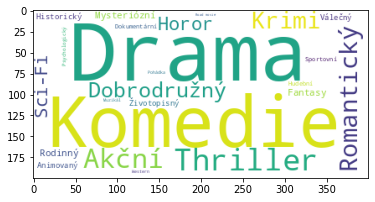

In [58]:
import wordcloud
import matplotlib.pyplot as plt 

item_count_list_genres = analyse_freq(movies['genres'])
genres, genre_counts = [list(t) for t in zip(*item_count_list_genres)]

wc = wordcloud.WordCloud(background_color='white')
wc.generate_from_frequencies(dict(zip(genres, genre_counts)))

plt.imshow(wc)

In [18]:
documents = movie_db.description.to_list()

simple_preprocess(documents[0])

['malý',
 'belgický',
 'detektiv',
 'hercule',
 'poirot',
 'david',
 'suchet',
 'knírkem',
 'upraveným',
 'dle',
 'pravítka',
 'neuvěřitelně',
 'bystrou',
 'šedou',
 'kůrou',
 'mozkovou',
 'řeší',
 'případy',
 'na',
 'které',
 'slavná',
 'britská',
 'policie',
 'ani',
 'scotland',
 'yard',
 'nestačí',
 'to',
 'již',
 'od',
 'roku',
 'dodnes',
 'této',
 'nejslavnější',
 'volně',
 'inspirované',
 'adaptaci',
 'předlohy',
 'královny',
 'detektivek',
 'agathy',
 'christie']

## LSA Model